In [ ]:
!pip install ultralytics
!pip install roboflow

  Using cached ultralytics-8.3.155-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import re
import numpy as np
import glob
import pandas as pd
import os
from ultralytics import YOLO

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="p097JrHP63OYlTZ1mmwQ")
project = rf.workspace("chi-b5fvz").project("cccd_info")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cccd_info-1 in yolov8:: 100%|██████████| 1237/1237 [00:00<00:00, 4604.61it/s]


In [ ]:
import os
import cv2

# Thư mục gốc chứa ảnh và label
image_dir = '/content/cccd_info-1/train/images'
label_dir = '/content/cccd_info-1/train/labels'
output_dir = 'cropped_ids_train'
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(label_dir):
    if not filename.endswith(".txt"):
        continue

    label_path = os.path.join(label_dir, filename)
    image_path = os.path.join(image_dir, filename.replace('.txt', '.jpg'))

    if not os.path.exists(image_path):
        continue

    image = cv2.imread(image_path)
    h, w, _ = image.shape

    raw_name = os.path.basename(image_path)
    clean_name = raw_name.split("_jpg.rf.")[0] + ".jpg"

    with open(label_path, 'r') as f:
        for i, line in enumerate(f):
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            if int(cls) != 1:
                continue

            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)

            crop = image[y1:y2, x1:x2]
            crop_filename = f"{clean_name[:-4]}.jpg"
            cv2.imwrite(os.path.join(output_dir, crop_filename), crop)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob, os

# --- Constants ---
AVG_W        = 17   # trung bình 1 chữ số rộng ~16px
SMOOTH_WIN   = 5     # window size for moving‐average
VALLEY_DEPTH = 0.2   # chỉ split khi valley < 20% max projection

def split_roi(roi, avg_w=AVG_W):
    """
    Tách một vùng ROI có thể chứa >1 chữ số:
    1) Morphological closing để lấp lỗ
    2) Tính projection dọc → smoothing
    3) Tìm valley thỏa threshold
    4) Lọc valley quá gần nhau
    5) Nếu không đủ, fallback chia đều
    """
    # 1) Close holes
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    clean  = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)
    h, w   = clean.shape

    # estimate số chữ số n
    n = max(1, int(round(w / avg_w)))
    if n == 1:
        return [roi]

    # 2) Projection & smoothing
    proj   = np.sum(clean, axis=0)
    smooth = np.convolve(proj, np.ones(SMOOTH_WIN)/SMOOTH_WIN, mode='same')

    # 3) Raw valleys
    raw = [i for i in range(1, w-1)
           if smooth[i-1] > smooth[i] < smooth[i+1]]
    thr = VALLEY_DEPTH * np.max(smooth)
    valleys = [i for i in raw if smooth[i] < thr]

    # 5) Chọn điểm split
    if len(valleys) >= n-1:
        splits = sorted(valleys)[:n-1]
    else:
        splits = [i * (w // n) for i in range(1, n)]
    splits = sorted(set(splits))

    # 6) Thực sự cắt
    parts, prev = [], 0
    for sp in splits + [w]:
        part = roi[:, prev:sp]
        if part.shape[1] > 3:
            parts.append(part)
        prev = sp

    return parts

# --- Main extraction function ---
def extract_digits_from_id(id_crop):


    # 1) Binarize
    gray   = cv2.cvtColor(id_crop, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(
      gray, 255,
      cv2.ADAPTIVE_THRESH_MEAN_C,
      cv2.THRESH_BINARY_INV,
      blockSize=23,  # odd window size, tweak between 11–31
      C=3.5          # constant subtracted from mean, tune 0–10
    )

    # 2) Find & sort contours
    cnts, _ = cv2.findContours(thresh,
                                cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)
    boxes = sorted((cv2.boundingRect(c) for c in cnts),
                   key=lambda b: b[0])

    digits = []
    for x, y, w, h in boxes:
        if h > 12 and w > 3:
            roi = thresh[y:y+h, x:x+w]

            # split ROI thành 1 hoặc nhiều chữ số
            subs = split_roi(roi)

            # với mỗi phần, pad vuông rồi resize về 28×28
            for part in subs:
                ph, pw = part.shape
                size   = max(ph, pw)
                dw, dh = size - pw, size - ph
                top,   bottom = dh//2, dh - dh//2
                left,  right  = dw//2, dw - dw//2

                padded = cv2.copyMakeBorder(
                    part,
                    top, bottom,
                    left, right,
                    borderType=cv2.BORDER_CONSTANT,
                    value=0
                )
                digit = cv2.resize(padded, (28, 28))
                digits.append(digit)

    return digits

img1390.jpg → 12 digits


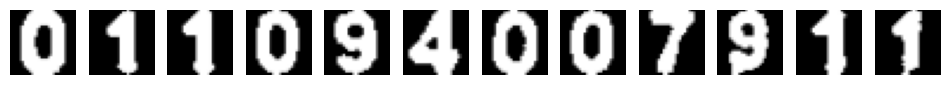

img1495.jpg → 12 digits


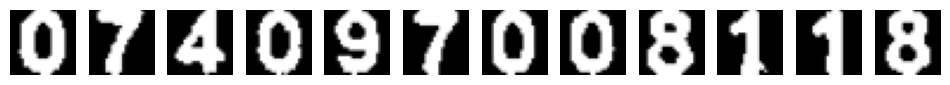

img1392.jpg → 12 digits


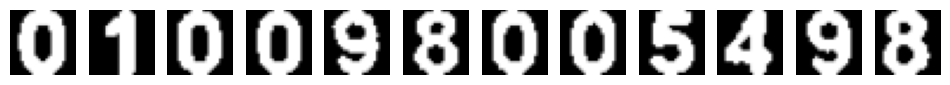

img1464.jpg → 12 digits


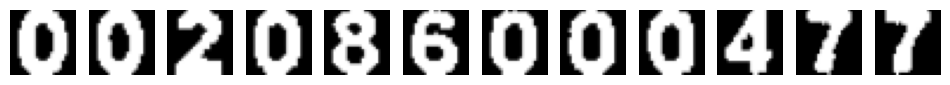

img1394.jpg → 12 digits


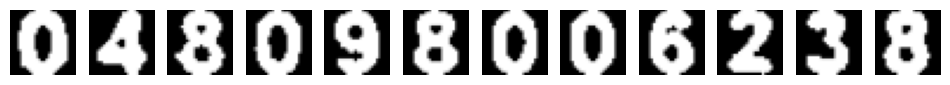

img1470.jpg → 12 digits


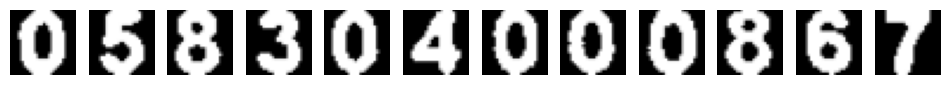

img1493.jpg → 12 digits


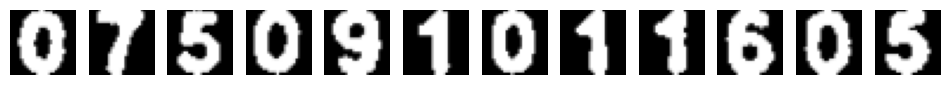

img1501.jpg → 12 digits


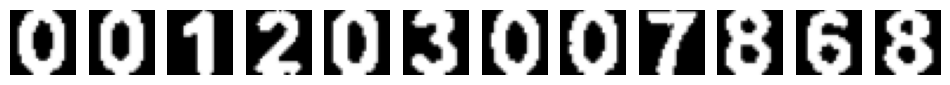

img1606.jpg → 12 digits


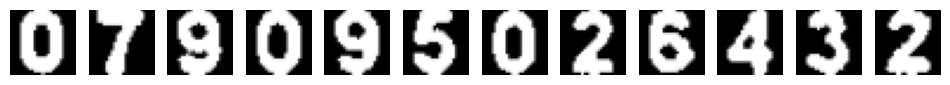

img1467.jpg → 12 digits


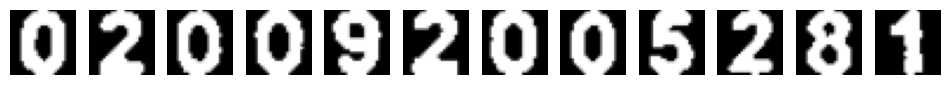

img1400.jpg → 12 digits


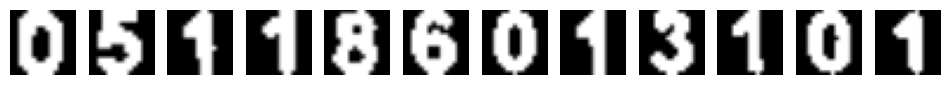

img1621.jpg → 12 digits


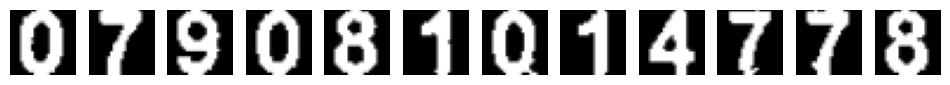

img1508.jpg → 12 digits


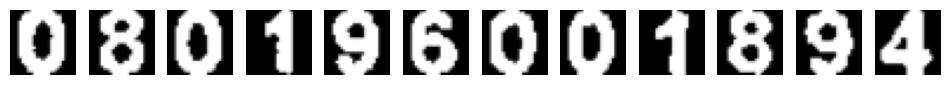

img1399.jpg → 12 digits


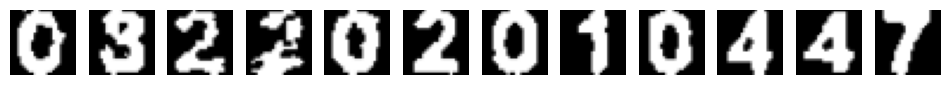

img1398.jpg → 12 digits


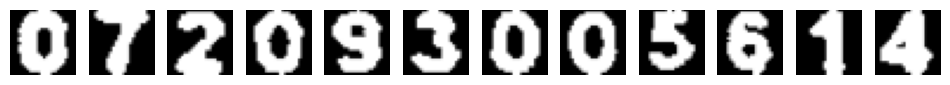

img1497.jpg → 12 digits


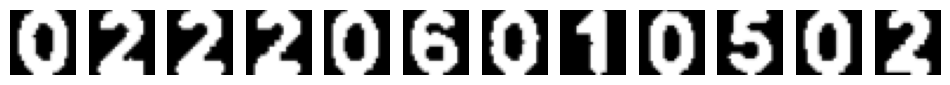

img1511.jpg → 12 digits


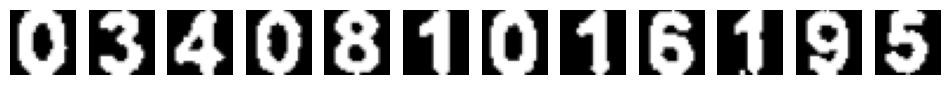

img1569.jpg → 12 digits


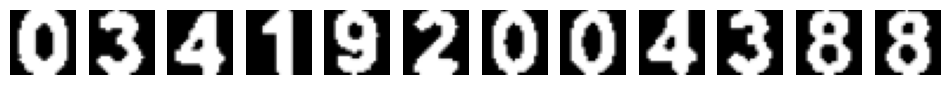

img1582.jpg → 12 digits


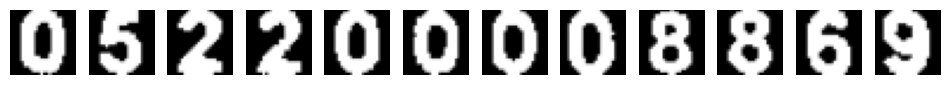

img1466.jpg → 12 digits


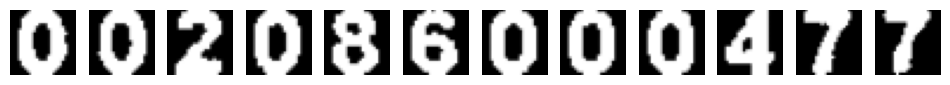

img1611.jpg → 12 digits


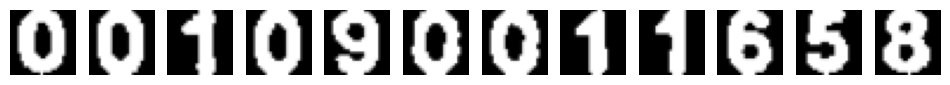

img1505.jpg → 12 digits


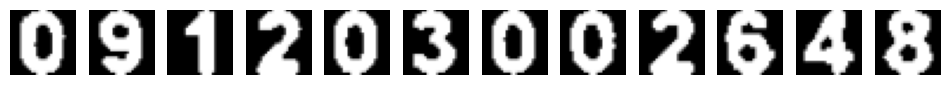

img911.jpg → 12 digits


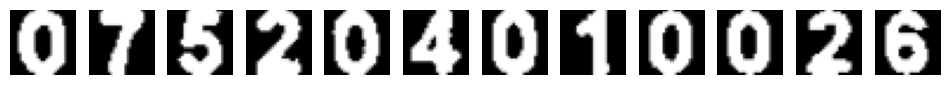

img1580.jpg → 12 digits


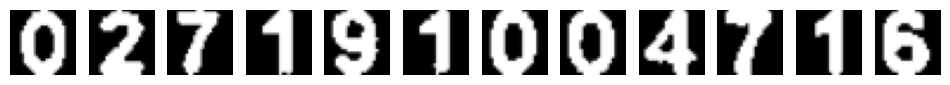

img1563.jpg → 12 digits


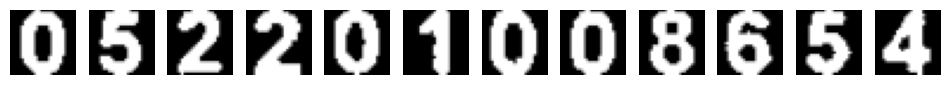

img1576.jpg → 12 digits


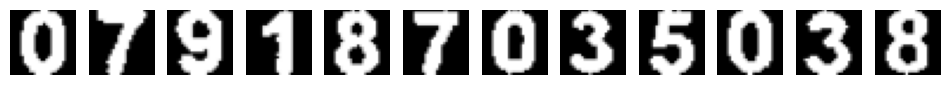

img1599.jpg → 12 digits


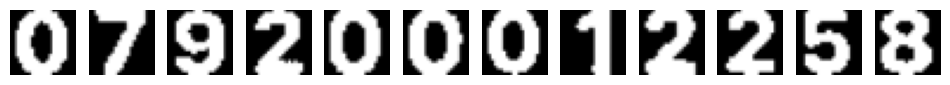

img1465.jpg → 12 digits


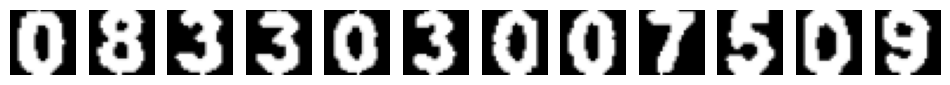

img1535.jpg → 12 digits


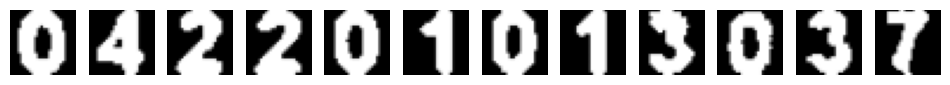

img1383.jpg → 12 digits


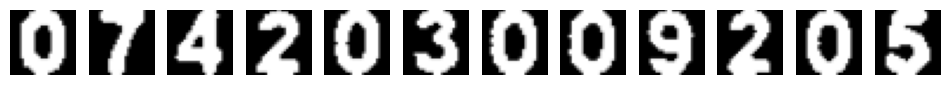

img1565.jpg → 12 digits


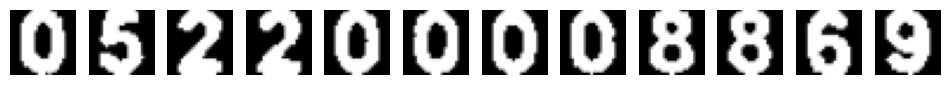

img932.jpg → 12 digits


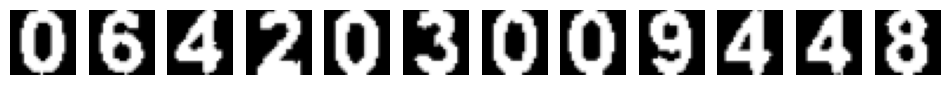

img1388.jpg → 12 digits


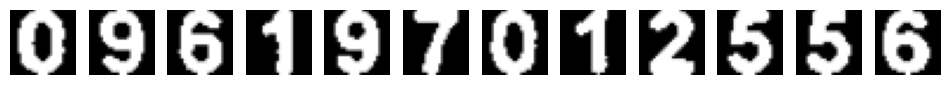

img1473.jpg → 12 digits


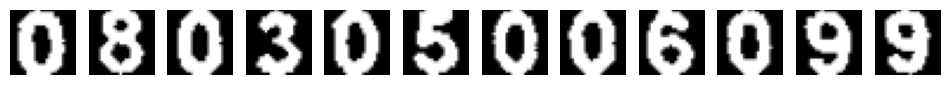

img1591.jpg → 12 digits


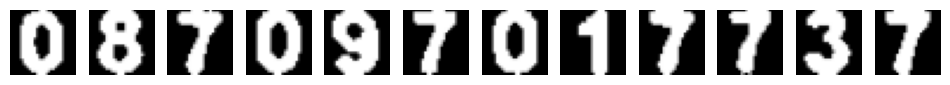

img1391.jpg → 12 digits


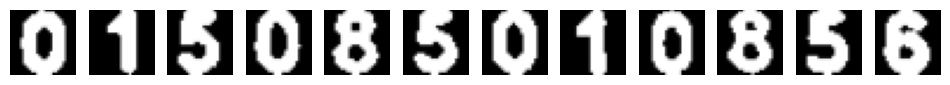

img953.jpg → 12 digits


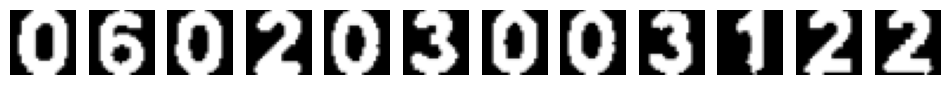

img1498.jpg → 12 digits


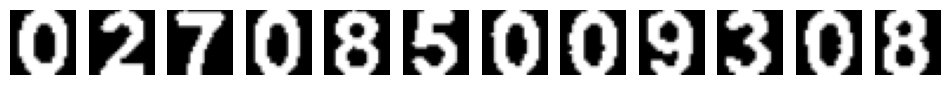

img1540.jpg → 12 digits


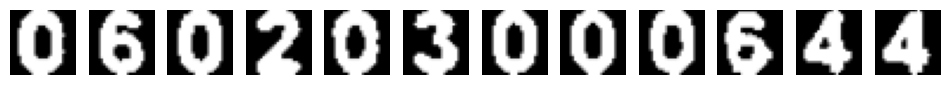

img1523.jpg → 12 digits


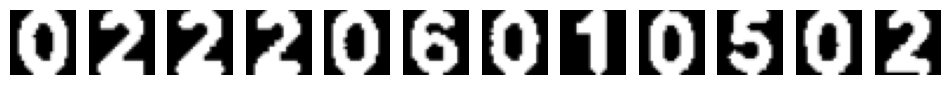

img1375.jpg → 12 digits


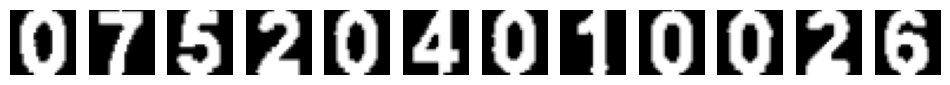

img1393.jpg → 12 digits


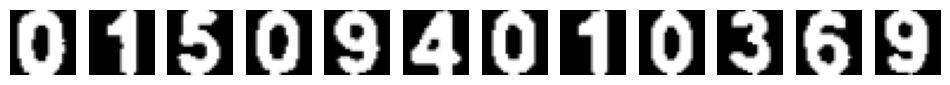

img1397.jpg → 12 digits


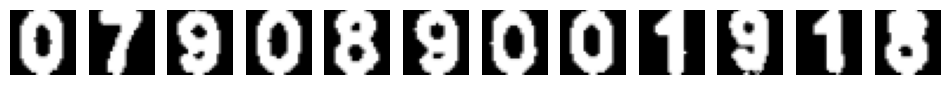

img1474.jpg → 12 digits


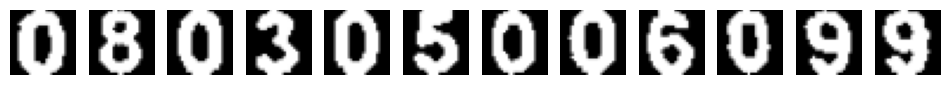

img1469.jpg → 12 digits


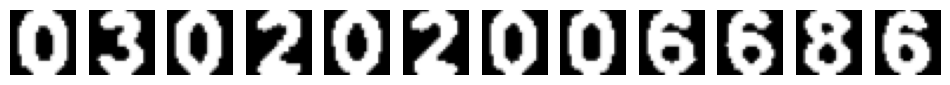

img1486.jpg → 12 digits


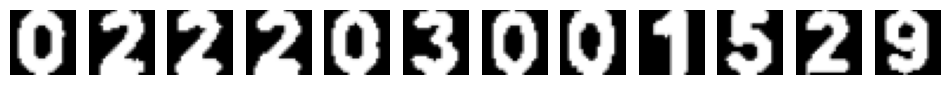

img1518.jpg → 12 digits


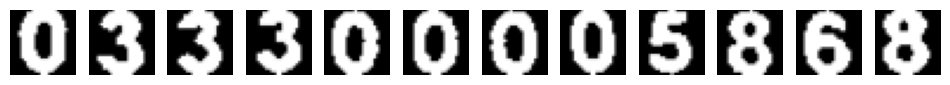

img1633.jpg → 12 digits


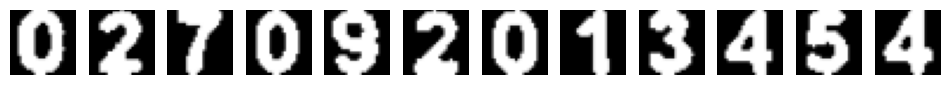

img1364.jpg → 12 digits


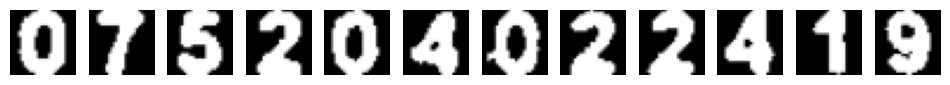

img1492.jpg → 12 digits


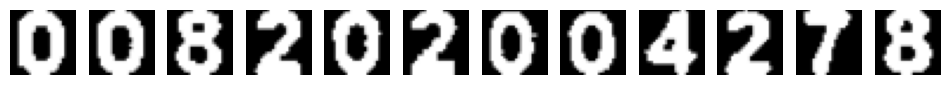

img1384.jpg → 12 digits


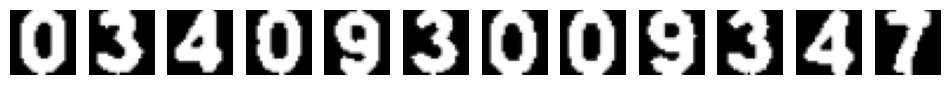

img1387.jpg → 12 digits


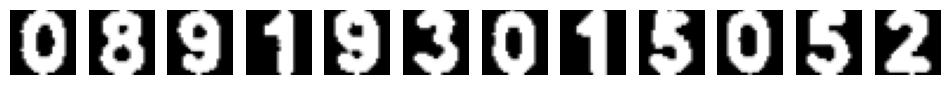

img1423.jpg → 12 digits


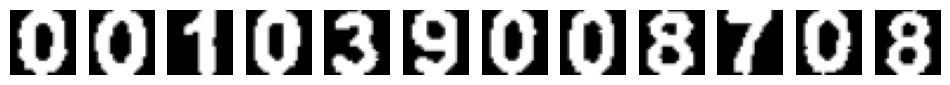

img1517.jpg → 12 digits


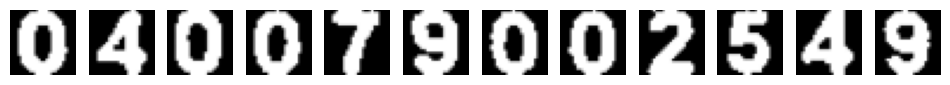

img1389.jpg → 12 digits


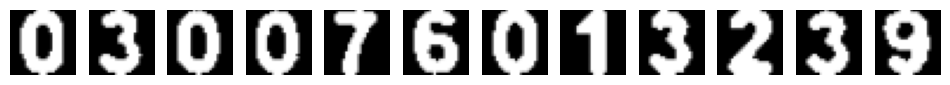

img1468.jpg → 12 digits


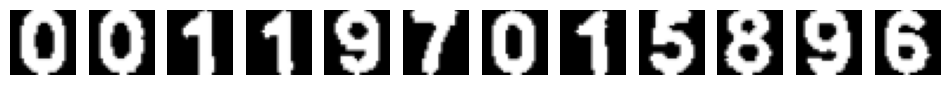

img1480.jpg → 12 digits


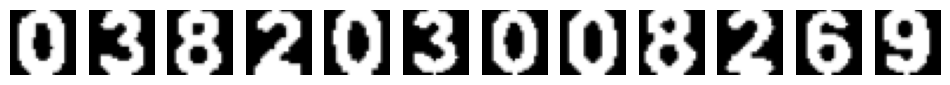

img1584.jpg → 12 digits


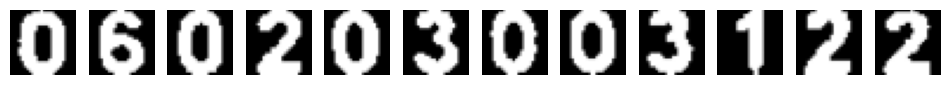

img1477.jpg → 12 digits


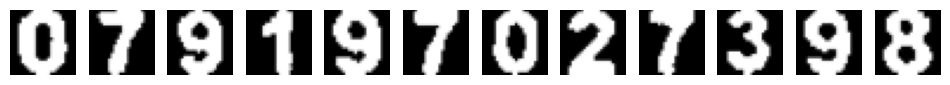

img994.jpg → 12 digits


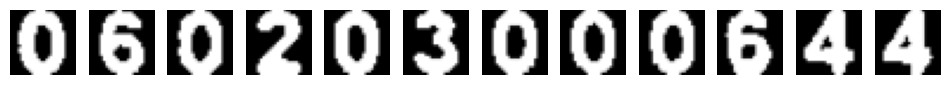

60


In [ ]:
image_paths = glob.glob('/content/cropped_ids_valid/*.jpg')
count = 0
for path in image_paths:
    id_crop = cv2.imread(path)
    digits = extract_digits_from_id(id_crop)

    # Chỉ in ra những ảnh không có đủ 12 chữ số
    if len(digits) == 12:
        print(f"{os.path.basename(path)} → {len(digits)} digits")
        count+=1
        plt.figure(figsize=(12,1))
        for i, digit in enumerate(digits):
            plt.subplot(1, len(digits), i + 1)
            plt.imshow(digit, cmap='gray')
            plt.axis('off')
        plt.show()
print(count)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob, os


# --- Main extraction function ---
def extract_digits_from_id_(id_crop):


    # 1) Binarize
    gray   = cv2.cvtColor(id_crop, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(
      gray, 255,
      cv2.ADAPTIVE_THRESH_MEAN_C,
      cv2.THRESH_BINARY_INV,
      blockSize=29,  # odd window size, tweak between 11–31
      C= 1.5          # constant subtracted from mean, tune 0–10
    )


    return thresh

img1400.jpg → 22 digits


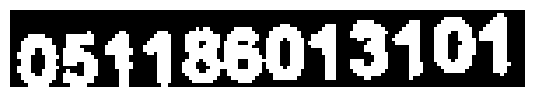

In [ ]:
path = '/content/cropped_ids_valid/img1400.jpg'
id_crop = cv2.imread(path)
digits = extract_digits_from_id_(id_crop)

print(f"{os.path.basename(path)} → {len(digits)} digits")
count+=1
plt.figure(figsize=(12,1))
plt.imshow(digits, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
!rm -rf extracted_digits_valid

In [ ]:

# 1) where your cropped ID images live, and where to dump digits
INPUT_GLOB   = '/content/cropped_ids_train/*.jpg'
OUTPUT_FOLDER = '/content/extracted_digits_train'

# 2) make sure the output folder exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 3) run extraction & save
for path in glob.glob(INPUT_GLOB):
    img   = cv2.imread(path)
    digs  = extract_digits_from_id(img)
    base  = os.path.splitext(os.path.basename(path))[0]

    for i, d in enumerate(digs):
        # filename: img1234_0.png, img1234_1.png, ...
        fn = f"{base}_{i:02d}.jpg"
        out = os.path.join(OUTPUT_FOLDER, fn)
        cv2.imwrite(out, d)


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving gt_2s.csv to gt_2s.csv


In [ ]:
import os
import glob
import shutil
import pandas as pd

# 1) Load and clean your CSV
df = pd.read_csv('ground_truth.csv', dtype=str)
# Strip .jpg/.png *before* setting index
df['filename'] = df['filename'].str.replace(r'\.jpe?g$|\.png$', '',
                                            regex=True)
df = df.set_index('filename')

# 2) Where to find your digit crops, and where to dump them
SRC_PATTERNS = {
    'train': 'extracted_digits_train/*.jpg',
    'valid': 'extracted_digits_valid/*.jpg'
}
OUT_ROOT = 'labeled_digits'  # will become labeled_digits/train/0…9 and labeled_digits/valid/0…9
os.makedirs(OUT_ROOT, exist_ok=True)

# 3) Loop over both splits
for split, pattern in SRC_PATTERNS.items():
    for src_path in glob.glob(pattern):
        base = os.path.basename(src_path)
        name, _ = os.path.splitext(base)

        # parse "<orig>_<idx>"
        try:
            orig, idx_str = name.rsplit('_', 1)
            idx = int(idx_str)
        except ValueError:
            print(f"Skipping {base}: bad format")
            continue

        # lookup the true ID string
        if orig not in df.index:
            print(f"Skipping {base}: no ground truth for '{orig}'")
            continue
        full_id = df.at[orig, 'id']

        # sanity check
        if not (0 <= idx < len(full_id)):
            print(f"Skipping {base}: idx {idx} out of range for '{full_id}'")
            continue

        digit = full_id[idx]

        # make target folder: labeled_digits/<split>/<digit>/
        dst_dir = os.path.join(OUT_ROOT, split, digit)
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(src_path, os.path.join(dst_dir, base))

    print(f"– done {split} split")

print("All crops have been labeled into train/ and valid/ folders.")


– done train split
– done valid split
All crops have been labeled into train/ and valid/ folders.


In [ ]:
import tensorflow as tf
from tensorflow import keras


In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    'labeled_digits/train',
    labels='inferred',
    label_mode='categorical',
    class_names=[str(i) for i in range(10)],
    color_mode='grayscale',
    batch_size=16,
    image_size=(28,28),
    shuffle=True,
    seed=123
)

valid_ds = keras.preprocessing.image_dataset_from_directory(
    'labeled_digits/valid',
    labels='inferred',
    label_mode='categorical',
    class_names=[str(i) for i in range(10)],
    color_mode='grayscale',
    batch_size=16,
    image_size=(28,28),
    shuffle=False
)
# 2) Prefetch for speed
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 2218 files belonging to 10 classes.
Found 720 files belonging to 10 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 1) Define where to save
checkpoint_path = "best.weights.h5"

# 2) Create the callback
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",         # or "val_accuracy"
    save_best_only=True,        # only keep the best model
    save_weights_only=True,     # only save the weights
    verbose=1
)



In [ ]:


# 3) Define the model
model = keras.Sequential([
    keras.layers.Rescaling(1./255, input_shape=(28,28,1)),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

# 4) Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# 5) Train on full dataset
epochs = 10
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb]

)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6773 - loss: 1.0949
Epoch 1: val_loss improved from inf to 0.00394, saving model to best.weights.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6799 - loss: 1.0866 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 2/10
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9901 - loss: 0.0542
Epoch 2: val_loss improved from 0.00394 to 0.00268, saving model to best.weights.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9901 - loss: 0.0542 - val_accuracy: 0.9986 - val_loss: 0.0027
Epoch 3/10
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9966 - loss: 0.0586
Epoch 3: val_loss improved from 0.00268 to 0.00243, saving model to best.weights.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9966 - loss: 0.0586 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 4/10
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9953 - loss: 0.0448
Epoch 4: val_loss improved from 0.00243 to 0.00206

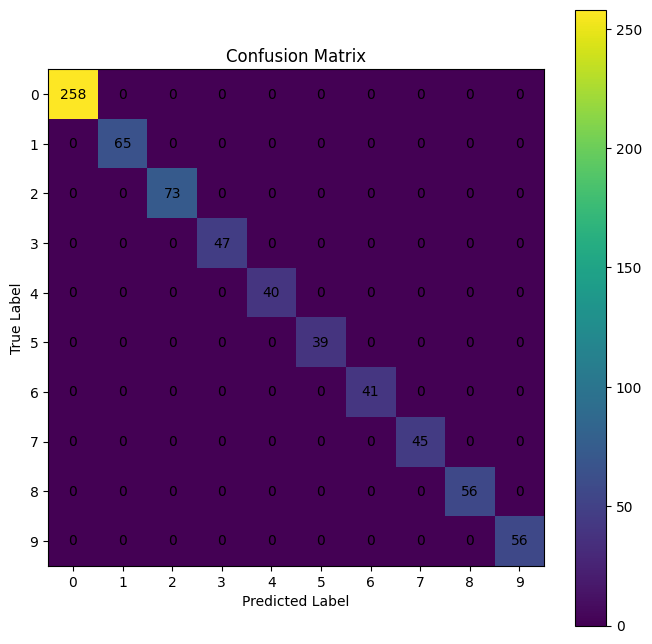

In [ ]:

from sklearn.metrics import confusion_matrix
model.load_weights("best.weights.h5")
y_true, y_pred = [], []
for images, labels in valid_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# 4) Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 5) Plot
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ticks = np.arange(10)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)

# Annotate counts
for i in range(10):
    for j in range(10):
        ax.text(j, i, cm[i, j], ha='center', va='center')

plt.colorbar(im, ax=ax)
plt.show()

In [ ]:
import glob, os
import numpy as np
import pandas as pd
from collections import defaultdict
import tensorflow as tf

# 1) Collect & sort all your digit‐crop files
file_paths = sorted(glob.glob('/content/extracted_digits_valid/*.jpg'))

# 2) Build a tf.data pipeline (no extra normalization—Rescaling layer handles it)
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [28,28])
    return img

ds = (
    tf.data.Dataset
      .from_tensor_slices(file_paths)
      .map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE)
)

# 3) Predict all digits
preds = model.predict(ds, verbose=0)
digit_preds = np.argmax(preds, axis=1)

# 4) Parse each filename into (card_key, digit_index)
orig_ids   = []
digit_idxs = []
for p in file_paths:
    name = os.path.splitext(os.path.basename(p))[0]
    key, idx = name.split('_')
    orig_ids.append(key)
    digit_idxs.append(int(idx))

# 5) Group & slot each predicted digit
grouped = defaultdict(lambda: [''] * 12)
for key, idx, d in zip(orig_ids, digit_idxs, digit_preds):
    grouped[key][idx] = str(d)

# 6) Join into full 12-digit strings
reconstructed = { key: ''.join(digits) for key, digits in grouped.items() }

# 7) (Optional) Dump to a DataFrame / CSV
df = pd.DataFrame([
    {'image_key': k, 'predicted_id': v}
    for k, v in sorted(reconstructed.items())
])
df.to_csv('merged_ids.csv', index=False)
print(df.head())


  image_key  predicted_id
0   img1364  075204022419
1   img1375  075204010026
2   img1383  074203009205
3   img1384  034093009347
4   img1387  089193015052


In [ ]:
import pandas as pd

# 1) Load
pred_df = pd.read_csv('merged_ids.csv',dtype=str)
gt_df   = pd.read_csv('ground_truth.csv',dtype=str)

# 2) Create a filename column in your predictions
pred_df['filename'] = pred_df['image_key'] + '.jpg'

# 3) Merge on filename ⇄ id
df = pred_df.merge(
    gt_df,
    left_on='filename',
    right_on='filename',
    how='inner'
)

# 4) Flag exact‐matches and compute card‐level accuracy
df['correct'] = df['predicted_id'] == df['id']
accuracy = df['correct'].mean() * 100

print(f"Accuracy: {accuracy:.2f}%")

# (Optional) See how many right vs wrong
print(df['correct'].value_counts())

# select only the mis-predicted rows
errors = df.loc[~df['correct']]

# — or, if you just want to see the keys and IDs:
print(errors[['image_key','filename','predicted_id','id']])

Accuracy: 100.00%
correct
True    60
Name: count, dtype: int64
Empty DataFrame
Columns: [image_key, filename, predicted_id, id]
Index: []


**TEST**

In [ ]:
from google.colab import files

# 1) Click “Choose Files” and pick your .zip (or other) archive
uploaded = files.upload()

KeyboardInterrupt: 

In [ ]:
!rm -rf test_id_images

In [ ]:
!unzip "/content/test_my_id_images.zip" -d /content/test_id_images

Archive:  /content/test_my_id_images.zip
  inflating: /content/test_id_images/4.jpg  
  inflating: /content/test_id_images/29.jpg  
  inflating: /content/test_id_images/img1.jpg  
  inflating: /content/test_id_images/28.jpg  
  inflating: /content/test_id_images/img6.jpg  
  inflating: /content/test_id_images/60.jpg  
  inflating: /content/test_id_images/54.jpg  
  inflating: /content/test_id_images/99.jpg  
  inflating: /content/test_id_images/img4.jpg  
  inflating: /content/test_id_images/78.jpg  
  inflating: /content/test_id_images/img3.jpg  
  inflating: /content/test_id_images/img2.jpg  
  inflating: /content/test_id_images/110.jpg  


img1.jpg → 12 digits


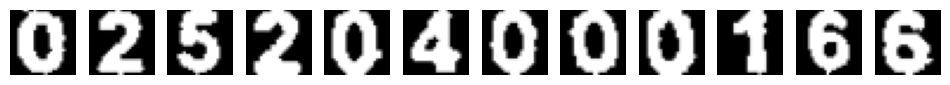

28.jpg → 12 digits


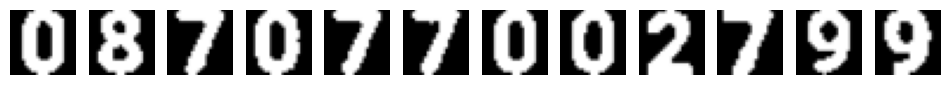

60.jpg → 12 digits


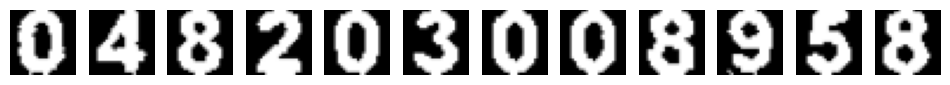

110.jpg → 12 digits


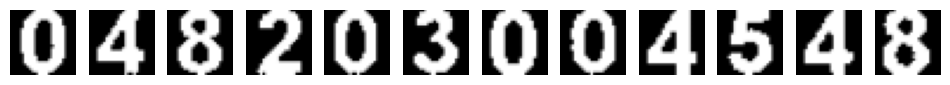

img6.jpg → 12 digits


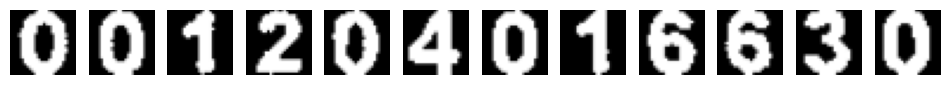

4.jpg → 12 digits


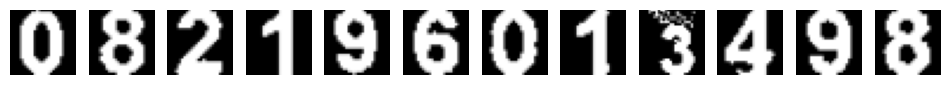

99.jpg → 12 digits


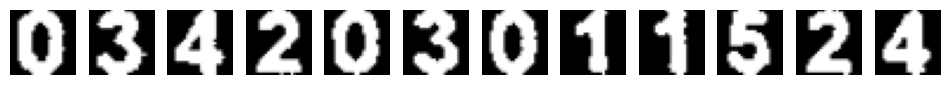

54.jpg → 12 digits


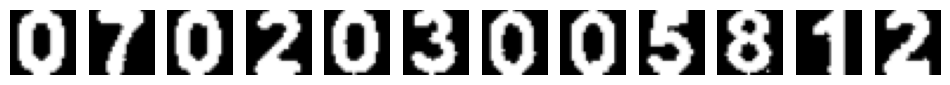

img2.jpg → 12 digits


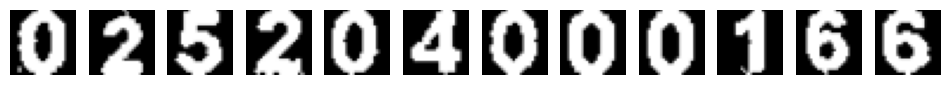

img4.jpg → 12 digits


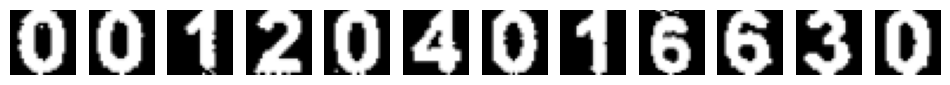

78.jpg → 12 digits


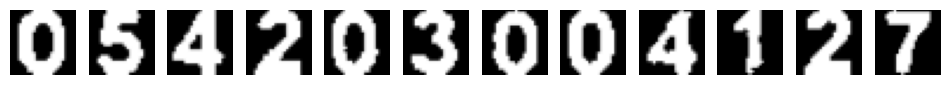

img3.jpg → 12 digits


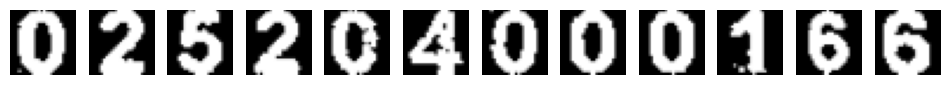

29.jpg → 12 digits


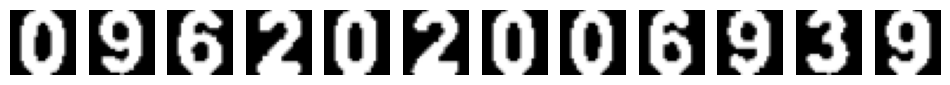

13


In [ ]:
import glob
import cv2
image_paths = glob.glob('/content/test_id_images/*.jpg')
count = 0
for path in image_paths:
    id_crop = cv2.imread(path)
    digits = extract_digits_from_id(id_crop)

    # Chỉ in ra những ảnh không có đủ 12 chữ số
    if len(digits) == 12:
        print(f"{os.path.basename(path)} → {len(digits)} digits")
        count+=1
        plt.figure(figsize=(12,1))
        for i, digit in enumerate(digits):
            plt.subplot(1, len(digits), i + 1)
            plt.imshow(digit, cmap='gray')
            plt.axis('off')
        plt.show()
print(count)

In [ ]:
!rm -rf extracted_digits_test

In [ ]:

# 1) where your cropped ID images live, and where to dump digits
INPUT_GLOB   = '/content/test_id_images/*.jpg'
OUTPUT_FOLDER = '/content/extracted_digits_test'

# 2) make sure the output folder exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 3) run extraction & save
for path in glob.glob(INPUT_GLOB):
    img   = cv2.imread(path)
    digs  = extract_digits_from_id(img)
    base  = os.path.splitext(os.path.basename(path))[0]

    for i, d in enumerate(digs):
        # filename: img1234_0.png, img1234_1.png, ...
        fn = f"{base}_{i:02d}.jpg"
        out = os.path.join(OUTPUT_FOLDER, fn)
        cv2.imwrite(out, d)


In [ ]:
import glob, os
import numpy as np
import pandas as pd
from collections import defaultdict
import tensorflow as tf

# 1) Collect & sort all your digit‐crop files
file_paths = sorted(glob.glob('/content/extracted_digits_test/*.jpg'))

# 2) Build a tf.data pipeline (no extra normalization—Rescaling layer handles it)
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [28,28])
    return img

ds = (
    tf.data.Dataset
      .from_tensor_slices(file_paths)
      .map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE)
)

# 3) Predict all digits
preds = model.predict(ds, verbose=0)
digit_preds = np.argmax(preds, axis=1)

# 4) Parse each filename into (card_key, digit_index)
orig_ids   = []
digit_idxs = []
for p in file_paths:
    name = os.path.splitext(os.path.basename(p))[0]
    key, idx = name.split('_',1)
    orig_ids.append(key)
    digit_idxs.append(int(idx))

# 5) Group & slot each predicted digit
grouped = defaultdict(lambda: [''] * 12)
for key, idx, d in zip(orig_ids, digit_idxs, digit_preds):
    grouped[key][idx] = str(d)

# 6) Join into full 12-digit strings
reconstructed = { key: ''.join(digits) for key, digits in grouped.items() }

# 7) (Optional) Dump to a DataFrame / CSV
df = pd.DataFrame([
    {'image_key': k, 'predicted_id': v}
    for k, v in sorted(reconstructed.items())
])
df.to_csv('merged_ids.csv', index=False)
print(df)


   image_key  predicted_id
0        110  048203004548
1         28  087077002799
2         29  096202006939
3          4  082196013498
4         54  070203005812
5         60  048203008958
6         78  054203004127
7         99  034203011524
8       img1  025204000166
9       img2  025204000166
10      img3  025204000166
11      img4  001204016630
12      img6  001204016630


In [ ]:
from google.colab import files
files.download('/content/merged_ids.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>